# Autoencoders convolucionales

En este cuaderno vamos a construir autoencoders convolucionales.

A diferencia de los autoencoders neuronales, aquí necesitamos una operación que *deshaga* el MaxPooling2D.

---

    [ES] Código de Alfredo Cuesta Infante para 'Reconocimiento de Patrones'
       @ Master Universitario en Visión Artificial, 2024, URJC (España)
    [EN] Code by Alfredo Cuesta-Infante for 'Pattern Recognition'
       @ Master of Computer Vision, 2024, URJC (Spain)

    alfredo.cuesta@urjc.es    

In [ ]:
#-[0]. General purpose packages

import numpy as np
import matplotlib.pyplot as plt

**Cargar el MNIST**

In [ ]:
#-[1]. Load images. Keras has a few benchmark datasets readily available.

from tensorflow.keras.datasets import mnist
(x_train, _), (x_test, _) = mnist.load_data()

#--- Get info of train and test data sets
N_train,dim0,dim1 = x_train.shape
N_test,dim0,dim1  = x_test.shape

### Construcción de la red
En esta celda hay varias cosas interesantes:
+ Como las imágenes del MNIST son $28\times28$, cuando aplicamos `MaxPooling2D((2,2))` 2 veces obtenemos un mapa de características $7\times7$. <br>
Si volvemos a aplicar `MaxPooling2D((2,2))`, como ambas dimensiones son impares, y el padding por defecto es "same", el resultado $3\times3$. <br>
Pero esto supone un problema al reconstruir el código latente, porque acabamos en una imágen que no tiene las mismas dimensiones que la imagen de entrada.
+ Este problema se ha resuelto modificando el padding como se muestra en el comentario del código.
+ Otro tema interesante es que se ha utilizad una activación lineal para la última capa.

In [ ]:
def encoder3 (x, filter_list, activation="relu"):
    h1 = Conv2D(filter_list[0], (3,3), activation=activation, padding="same")(x)
    p1 = MaxPooling2D((2,2))(h1)
    h2 = Conv2D(filter_list[1], (3,3), activation=activation, padding="same")(p1)
    p2 = MaxPooling2D((2,2))(h2)
    h3 = Conv2D(filter_list[2], (3,3), activation=activation, padding="same")(p2)
    code = MaxPooling2D((2,2), padding="same")(h3) #<-- padding = "same" !!
    return code

def decoder3 (x, filter_list, activation="relu"):
    h1 = Conv2D(filter_list[0], (3, 3), activation='relu', padding='same')(x)
    h2 = UpSampling2D((2, 2))(h1)
    h3 = Conv2D(filter_list[1], (3, 3), activation='relu', padding='same')(h2)
    h4 = UpSampling2D((2, 2))(h3)
    h5 = Conv2D(filter_list[2], (3, 3), activation='relu', padding='valid')(h4) #<-- padding = "valid" !!
    h6 = UpSampling2D((2, 2))(h5)
    y  = Conv2D(1,(3,3),  activation='linear', padding='same')(h6)
    return y

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation
from tensorflow.keras.layers import Flatten, Dense, UpSampling2D
from tensorflow.keras.models import Model

#- Input layer
x = Input( shape=(dim0, dim1, 1) )
#- encoder with 3 conv.layers
filter_list = [5,15,25]
code = encoder3(x, filter_list)
#- decoder with 3 conv.layers
filter_list = [25,15,5]
x_pred = decoder3(code, filter_list)
#- Put all in a model and compile
ae = Model(x,x_pred)
ae.compile(optimizer='adam', loss='mse')
ae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 5)         50        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 5)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 15)        690       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 15)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 25)          3400  

## Aprendizaje

**1. Preparamos el conjunto de datos para que pueda ser procesado por el modelo**  <br>
       _En este caso NO hace falta serializar las imágenes ya que la entrada de las CNN es típicamente imágenes._<br>
       Es importante reflejar la profundidad de color. Normalmente será 1 para imágenes en escala de grises y 3 para RGB. <br>
       Pero podría ser otro, por ejemplo 4 para RGB-D
       
**2. Preparamos también el vector de etiquetas para que tenga una representación 1-hot**

In [ ]:
x_tensor = x_train.reshape((N_train,dim0,dim1,1))

**3. Ejecutar el método FIT**<br>
Tensorflow sigue el estandar de Scikit-Learn. Pero a diferencia de otros métodos que hemos visto de ML, en DL hay que especificar algunas otra opciones como el número de épocas o el tamaño del lote.
+ El **número de épocas** indica cuantas veces se utiliza el conjunto de entrenamiento para realizar el aprendizaje
+ El **tamaño del lote** es el número de muestras que se utilizan para calcular el descenso del gradiente.

In [ ]:
# Train the model, iterating on the data in batches of 32 samples

N_epochs = 1
batch_size = 32
ae.fit(x_tensor, x_tensor, epochs=N_epochs, batch_size=batch_size)

1875/1875 [==============================] - 31s 16ms/step - loss: 1533.4395


## Test

**1. Debemos procesar los datos de test igual que procesamos los de entrenamiento**

In [ ]:
x_test_flat = x_test.reshape((N_test,dim0,dim1,1))

**2. ejecutar el método PREDICT**

In [ ]:
x_reconstructed = ae.predict( x_test_flat )

313/313 [==============================] - 3s 10ms/step


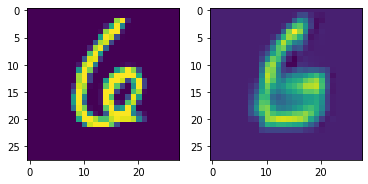

In [ ]:
k = 123
plt.subplot(121)
plt.imshow(x_test[k,:].reshape([28,28]))
plt.subplot(122)
plt.imshow(x_reconstructed[k,:].reshape([28,28]))